In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
# Camera Calibration
images = glob.glob("camera_cal/calibration*.jpg")

objpoints = []
imgpoints = []

objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

for frame in images:
    img = mpimg.imread(frame)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], \
                                                   None, None)

#for frame in images:
#    img = mpimg.imread(frame)
#    dst = cv2.undistort(img, mtx, dist, None, mtx)

In [70]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelxy = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return binary_output

def color_thresh(img, s_thresh=(180, 255), r_thresh=(100,200)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    R = img[:, :, 0]
    binary_r = np.zeros_like(gray)
    binary_r[(R > r_thresh[0]) & (R < r_thresh[1])] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:, :, 2]
    binary_s = np.zeros_like(gray)
    binary_s[(S > s_thresh[0]) & (S < s_thresh[1])] = 1
    
    binary_output = np.zeros_like(gray)
    binary_output[(binary_r == 1) & (binary_s == 1)] = 1
    return binary_output

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def detect_lane_line(img, mtx, dist):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    vertices = np.array([[(img.shape[1]//8, img.shape[0]), (img.shape[1], img.shape[0]), \
               (img.shape[1]//2, img.shape[0]*5//9), (img.shape[1]//2+20, img.shape[0]*5//9)]])
    
    output = np.zeros_like(gray)
    color = color_thresh(undist, (100, 255), (90, 255))
    gdx = abs_sobel_thresh(undist, orient='x', sobel_kernel=3, thresh_min=30, thresh_max=255)
    mag = mag_thresh(undist, sobel_kernel=3, mag_thresh=(50, 255))
    dirt = dir_thresh(undist, sobel_kernel=15, thresh=(0.7, 1.3))
    output[(color == 1) | (mag == 1) & (gdx == 1) & (dirt == 1)] = 1
    masked_img = region_of_interest(output, vertices)
    return masked_img

def perspective_transform(img):

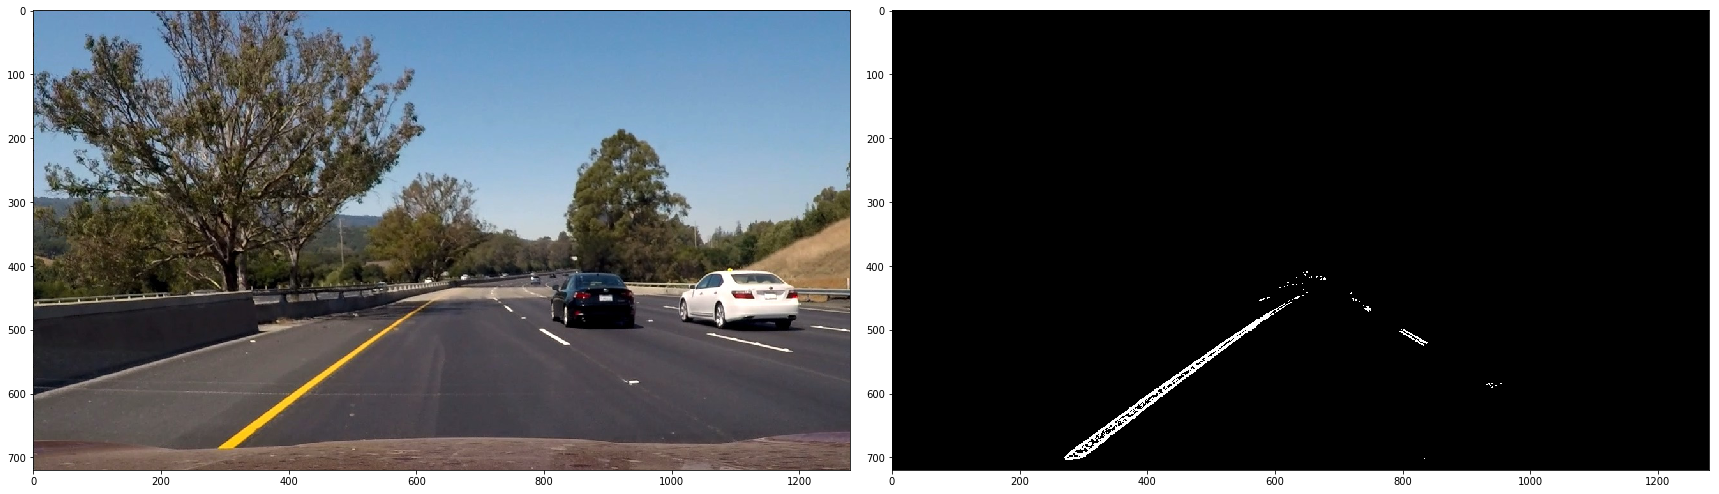

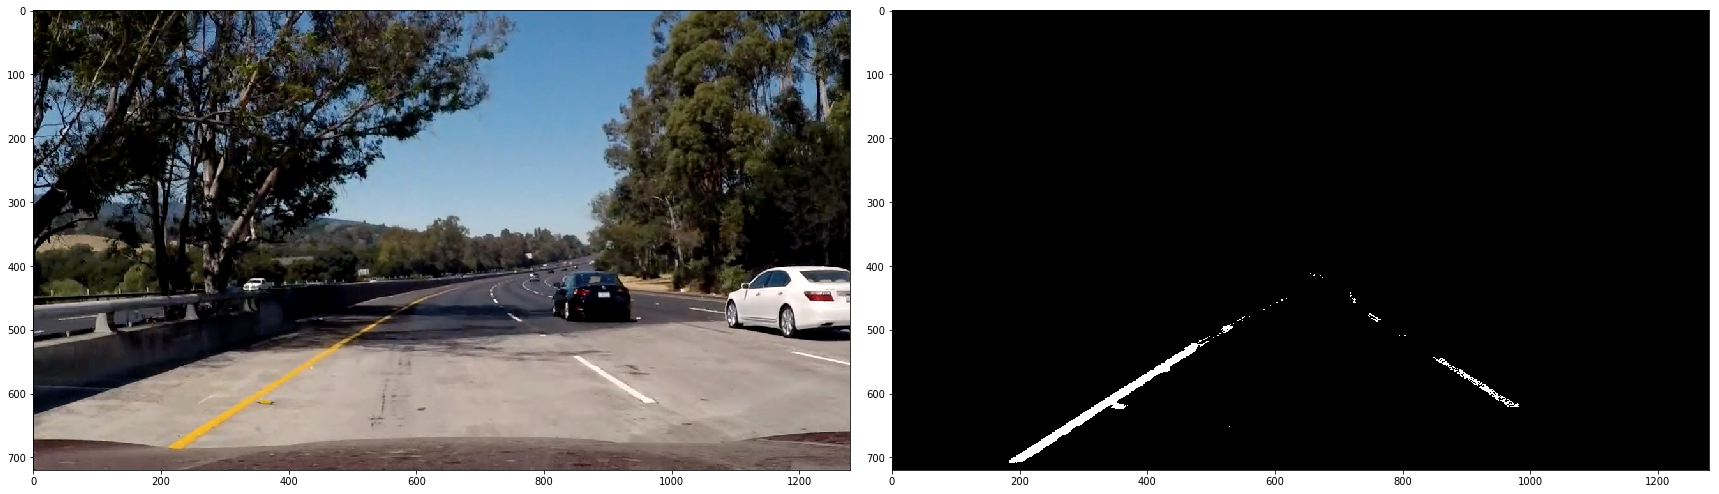

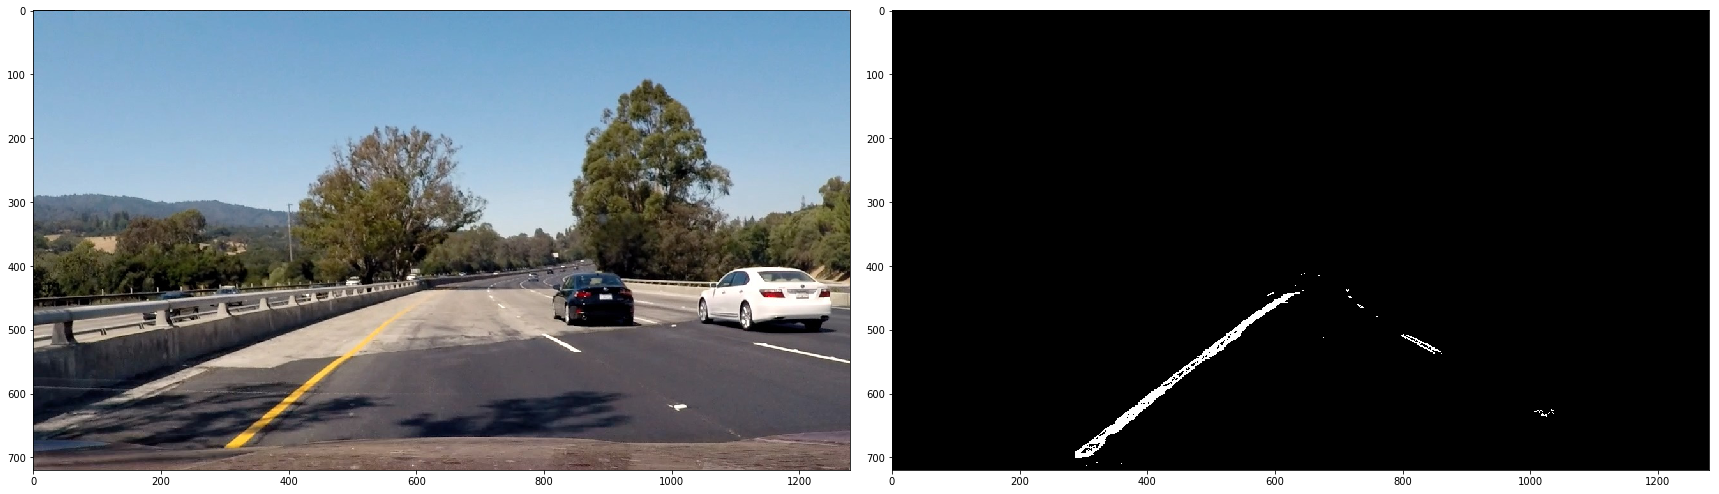

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


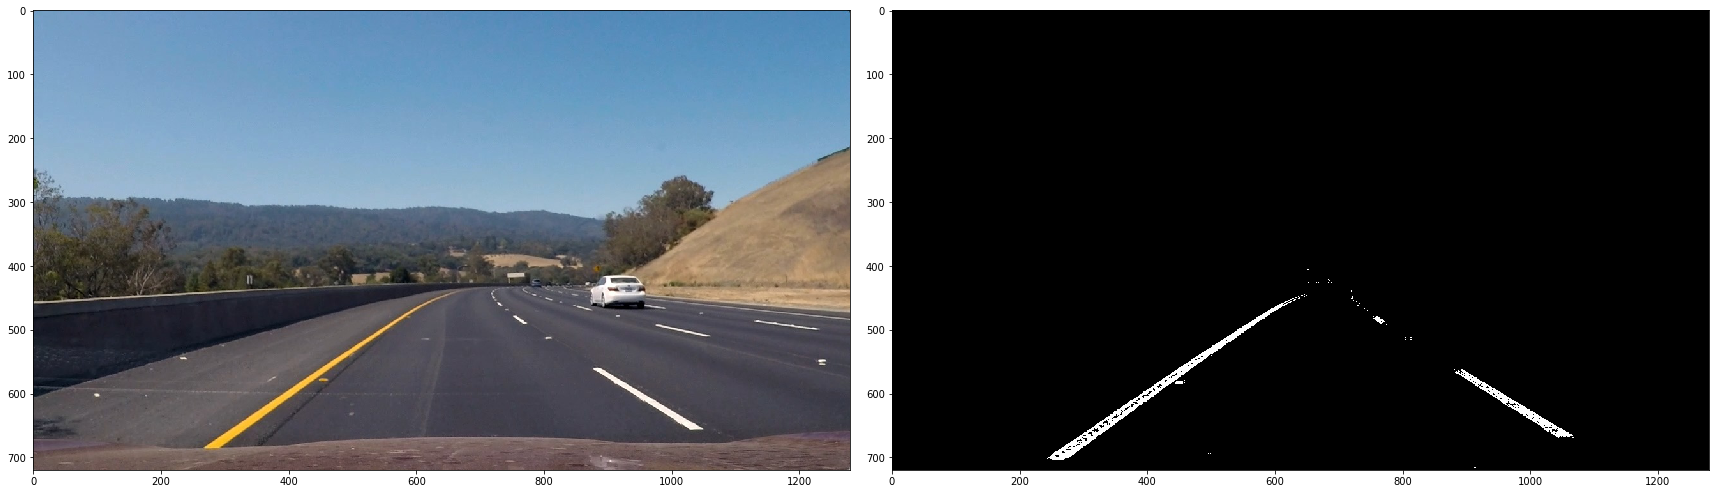

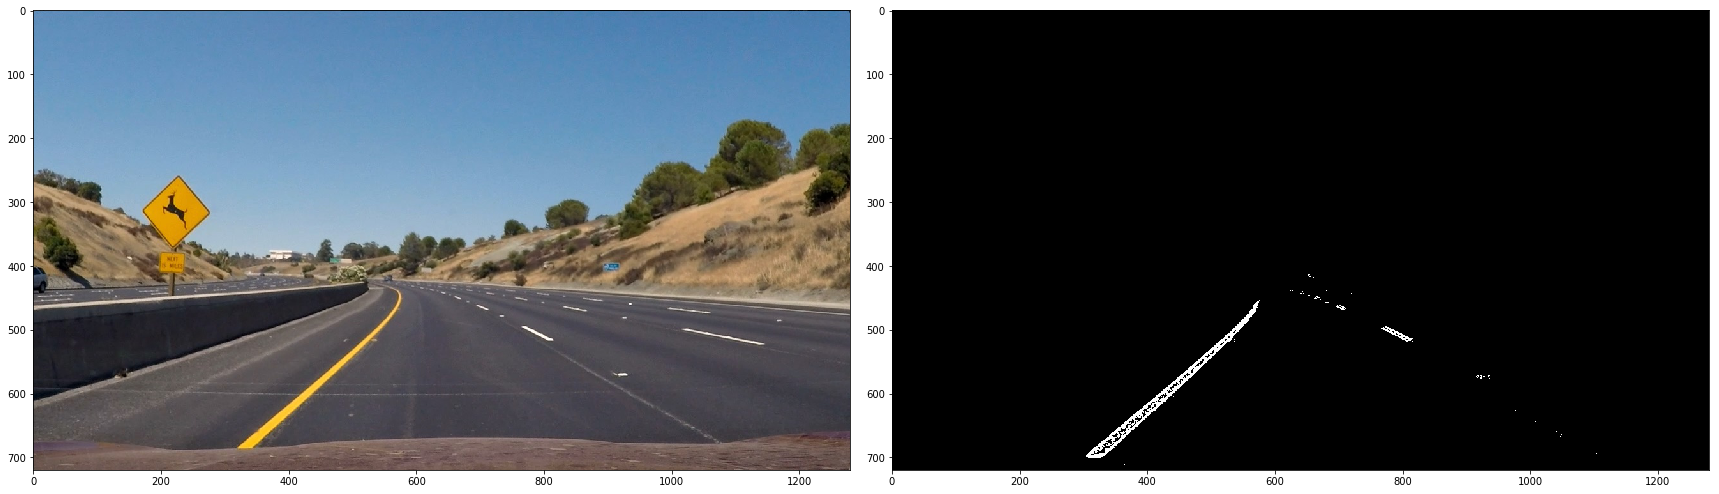

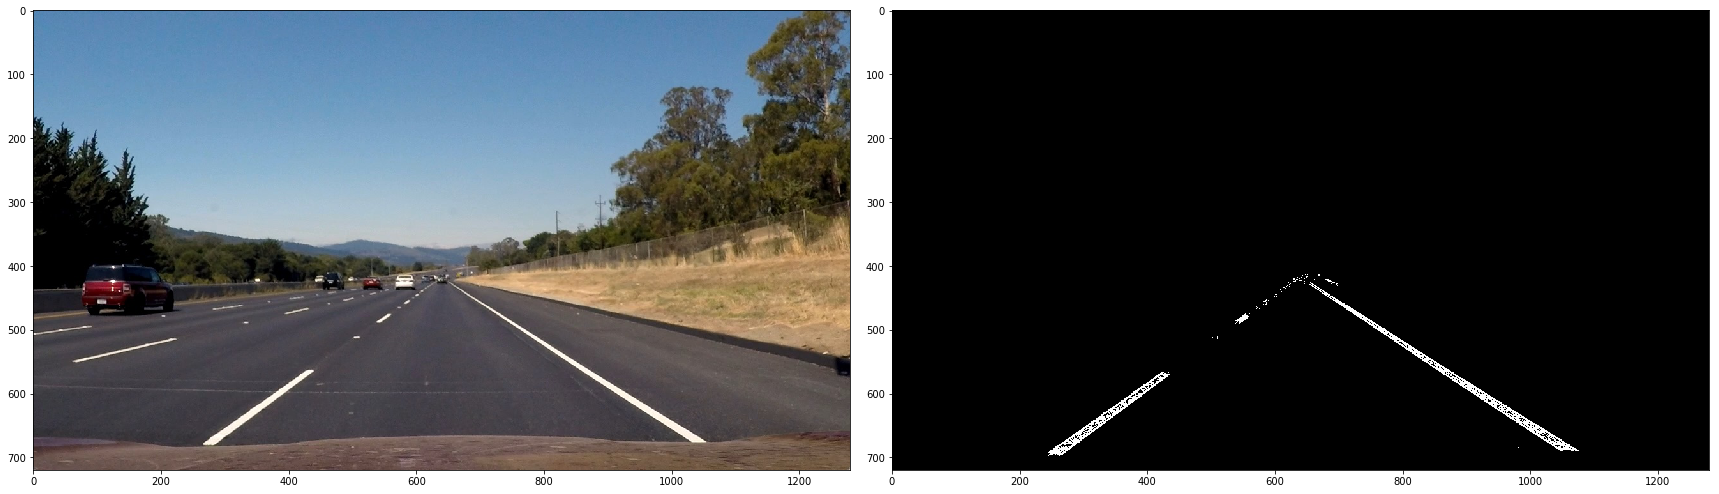

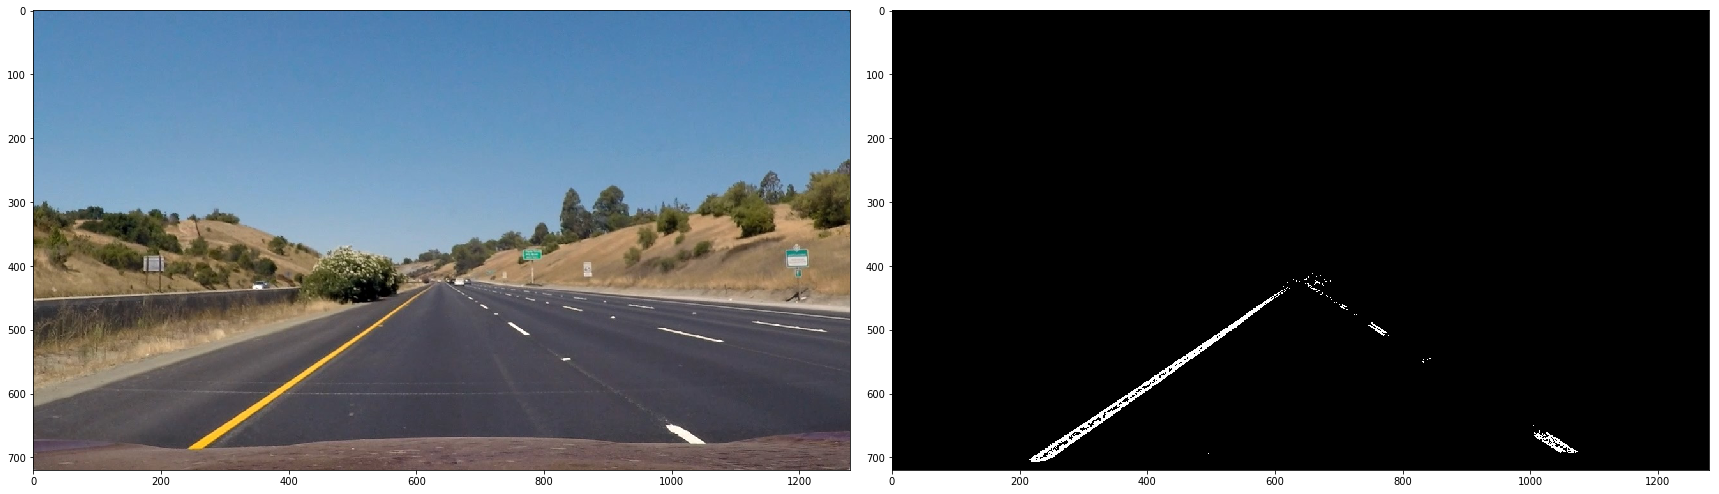

In [72]:
# Gradient & color threhold
images = glob.glob("test_images/*.jpg")

for frame in images:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    img = mpimg.imread(frame)
    ax1.imshow(img)
    
    output = detect_lane_line(img, mtx, dist)
    ax2.imshow(output, cmap='gray')